# Import required libraries for calculating footprints and clustering

In [1]:
import numpy as np
import pandas as pd
import scipy.io
import scipy
import xlrd, xlsxwriter
import copy

from sompy.sompy import SOMFactory
from sompy.visualization.mapview import View2D
from sompy import umatrix
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView

from sklearn.cluster import AffinityPropagation, AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score

CACHEDIR=C:\Users\Gilang Hardadi\.matplotlib
Using fontManager instance from C:\Users\Gilang Hardadi\.matplotlib\fontlist-v330.json
Loaded backend module://ipykernel.pylab.backend_inline version unknown.
Loaded backend module://ipykernel.pylab.backend_inline version unknown.


# Extract expenditure information from survey data (EVS 2013)

The individual characteristics (education, job, etc.) are represented by the head of household (ef8u1 = 1).

In [2]:
folder = "C:\\Users\\Gilang Hardadi\\Documents\\EVS 2013\\"
EVS_13 = pd.read_csv(folder + "suf_evs_2013_pers_gf6_slr\\daten\\evs_pers2013_slr.csv", delimiter=";")

In [3]:
EVS_13 = EVS_13[EVS_13["ef8u1"] == 1]
EVS_13

NumExpr defaulting to 8 threads.


,ef1,ef2u1,ef2u2,ef2u3,ef5,ef6,ef7,ef8u1,ef8u2,ef8u3,...,ef525,ef526,ef527,ef528,ef529,ef530,ef531,ef532,ef533,ef534
0,33,1,1,1,2,1,3,1,1,1970,...,84,0,0,0,0,0,71,0,0,2145.925926
3,33,1,2,1,3,2,4,1,1,1966,...,495,654,0,0,0,0,0,0,0,1630.666667
7,33,1,3,1,3,3,4,1,1,1977,...,0,0,0,0,0,0,130,0,0,1221.904762
11,33,1,4,1,2,2,3,1,1,1980,...,0,114,0,0,0,0,0,0,0,1760.370370
14,33,1,5,1,3,3,4,1,1,1970,...,165,501,1000,0,0,0,0,0,0,1459.841270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110636,44,16,52417,1,4,4,2,1,1,1953,...,1040,0,0,0,0,0,94,0,0,1752.888889
110638,44,16,52418,1,4,4,4,1,1,1985,...,0,330,0,0,0,0,0,0,0,1459.047619
110642,44,16,52419,1,4,4,2,1,1,1976,...,0,315,0,0,0,0,0,0,0,3196.222222
110644,44,16,52420,1,6,4,4,1,1,1973,...,150,249,0,0,0,0,0,0,0,1184.126984


# Extract product aggregation and carbon intensity information

In [4]:
Aggregate = pd.read_csv("Footprint_Aggregate.csv")
Intensity = pd.read_csv("Footprint_Intensity.csv")

In [5]:
AggregateID = Aggregate.iloc[:,2].values
IntensityID = Intensity.iloc[:,2].values

print(AggregateID)
print(IntensityID)

[ 0  1  2  3  3  4  5  5  5  6  7  7  8  8  8  8  9 83 10 10 10 83 83 12
 12 10 11 11 11 11 11 11 11 12 12 13 83 83 13 14 83 83 14 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 15 15 83 83 83 83 83 16
 83 83 17 83 83 18 19 20 83 83 20 20 83 83 83 83 83 83 83 21 22 22 23 24
 24 25 25 25 25 26 27 27 28 29 29 29 30 30 31 32 32 33 33 83 83 83 34 34
 83 83 83 35 35 35 35 35 36 37 38 38 39 40 40 41 42 42 43 43 44 45 46 47
 47 48 48 49 50 51 51 51 51 51 51 52 52 53 54 55 56 57 58 59 60 60 61 61
 62 63 63 63 63 63 63 63 63 64 64 65 66 67 68 69 69 70 71 72 72 72 72 72
 73 73 73 74 75 75 75 76 77 77 77 74 78 78 79 80 80 80 80 81 82 74]
[0.598 0.353 0.237 0.067 0.658 0.608 0.393 0.163 0.584 0.163 0.124 0.124
 0.117 0.4   0.049 1.161 1.737 4.36  4.88  2.546 0.875 0.313 0.391 0.163
 0.645 0.406 0.273 0.163 0.4   0.285 0.339 0.853 0.163 0.937 0.546 0.25
 0.2   0.2   0.121 0.2   0.253 0.253 0.356 0.276 2.423 0.262 0.252 0.267
 1.238 0.069 0.565 0.069 0.565 0.565 0.501 0.105 0.211 0.

# Write a function to build an aggregation matrix

Copied from PySUT library (built by Konstantin Stadler)

In [6]:
def MI_Tuple(value, Is): 
    """
    Define function for obtaining multiindex tuple from index value
    value: flattened index position, Is: Number of values for each index dimension
    Example: MI_Tuple(10, [3,4,2,6]) returns [0,0,1,4]
    MI_Tuple(138, [100,10,5]) returns [2,7,3]
    MI_Tuple is the inverse of Tuple_MI.
    """
    IsValuesRev = []
    CurrentValue = value
    for m in range(0,len(Is)):
        IsValuesRev.append(CurrentValue % Is[len(Is)-m-1])
        CurrentValue = CurrentValue // Is[len(Is)-m-1]
    return IsValuesRev[::-1]    

def Tuple_MI(Tuple, IdxLength): 
    """
    Function to return the absolution position of a multiindex when the index tuple
    and the index hierarchy and size are given.
    Example: Tuple_MI([2,7,3],[100,10,5]) returns 138
    Tuple_MI([0,0,1,4],[3,4,2,6]) returns 10
    Tuple_MI is the inverse of MI_Tuple.
    """
    # First, generate the index position offset values
    IdxShift =  IdxLength[1:] +  IdxLength[:1] # Shift 1 to left
    IdxShift[-1] = 1 # Replace lowest index by 1
    IdxShift.reverse()
    IdxPosOffset = np.cumproduct(IdxShift).tolist()
    IdxPosOffset.reverse()
    Position = np.sum([a*b for a,b in zip(Tuple,IdxPosOffset)])
    return Position

def build_Aggregation_Matrix(Position_Vector): # from PySUT
    """Turn a vector of target positions into a matrix that aggregates 
    or re-arranges rows of the table it is multiplied to from the left 
    (or columns, if multiplied transposed from the right)"""
    AM_length = Position_Vector.max() + 1 # Maximum row number of new matrix (+1 to get the right length, as 0 is the smallest target position entry.)
    AM_width  = len(Position_Vector) # Number of rows of the to-be-aggregated matrix
    Rearrange_Matrix = np.zeros((AM_length,AM_width))
    for m in range(0,len(Position_Vector)):
        Rearrange_Matrix[Position_Vector[m].item(0),m] = 1 # place 1 in aggregation matrix at [PositionVector[m],m], so that column m is aggregated with Positionvector[m] in the aggregated matrix
    return Rearrange_Matrix

In [7]:
Aggregation_Matrix_Rows = build_Aggregation_Matrix(AggregateID)

print(Aggregation_Matrix_Rows)
print(Aggregation_Matrix_Rows.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(84, 214)


# Select and aggregate the household expenditure data

Aggregation is conducted via matrix multiplication of aggregation matrix and household expenditure data

In [8]:
Cons_DE13 = EVS_13.iloc[:,241:455].values
ConsAg = Cons_DE13.dot(Aggregation_Matrix_Rows.transpose())
print(ConsAg.shape)

(52421, 84)


In [11]:
ConsAg[:,0:83].sum(axis=1)

array([9590., 8852., 6320., ..., 7092., 8779., 2603.])

In [12]:
a,b = ConsAg.shape[0],ConsAg.shape[1]-1
Footprint = np.zeros((a,b))

for i in range(0,a):
    for j in range(0,b):
        Footprint[i,j] = 4 * ConsAg[i,j] * IntensityID[j]

print(Footprint)

[[2906.28   353.      11.376 ...    0.       0.       8.568]
 [2633.592  348.764   11.376 ...    0.       0.       0.   ]
 [2533.128  242.864   12.324 ...    0.       0.       0.   ]
 ...
 [2011.672  163.792   28.44  ...    0.       0.     240.38 ]
 [3410.992    0.      47.4   ...  181.56     0.     216.58 ]
 [ 382.72    32.476   28.44  ...    0.       0.       0.   ]]


In [14]:
FP_header = Intensity.iloc[:,1].values
print(FP_header)

['Food' 'Non-alcoholic beverages' 'Alcoholic beverages' 'Tobacco'
 'Clothing materials' 'Garments'
 'Other articles of clothing and clothing accessories'
 'Cleaning, repair and hire of clothing' 'Shoes and other footwear'
 'Repair and hire of footwear' 'Actual rentals paid by tenants'
 'Imputed rentals of owner-occupiers' 'Rent for garage'
 'Materials for the maintenance and repair of the dwelling'
 'Services for the maintenance and repair of the dwelling'
 'Operating costs paid by tenants' 'Electricity' 'Gas' 'Liquid fuels'
 'Solid fuels' 'Heat energy' 'Furniture and furnishing'
 'Carpets and other floor coverings'
 'Repair of furniture, furnishings and floor coverings'
 'Household textiles' 'Major household appliances whether electric or not'
 'Small electric household appliances' 'Repair of household appliances'
 'Glassware, tableware and household utensils' 'Major tools and equipment'
 'Small tools and miscellaneous accessories' 'Non-durable household goods'
 'Domestic services and

# Create a dataframe of household characteristics and product footprints

Categorical variables are converted into numerical variables using one-hot encoding.

In [15]:
Bundes = EVS_13.iloc[:,1].values
Bundes_SH = np.zeros((Bundes.shape))
Bundes_HH = np.zeros((Bundes.shape))
Bundes_NI = np.zeros((Bundes.shape))
Bundes_HB = np.zeros((Bundes.shape))
Bundes_NW = np.zeros((Bundes.shape))
Bundes_HE = np.zeros((Bundes.shape))
Bundes_RP = np.zeros((Bundes.shape))
Bundes_BW = np.zeros((Bundes.shape))
Bundes_BY = np.zeros((Bundes.shape))
Bundes_SL = np.zeros((Bundes.shape))
Bundes_BE = np.zeros((Bundes.shape))
Bundes_BB = np.zeros((Bundes.shape))
Bundes_MV = np.zeros((Bundes.shape))
Bundes_SN = np.zeros((Bundes.shape))
Bundes_ST = np.zeros((Bundes.shape))
Bundes_TH = np.zeros((Bundes.shape))

for i in range(0, Bundes.shape[0]):
    if Bundes[i] == 1:
        Bundes_SH[i] = 1 
    elif Bundes[i] == 2:
        Bundes_HH[i] = 1
    elif Bundes[i] == 3:
        Bundes_NI[i] = 1
    elif Bundes[i] == 4:
        Bundes_HB[i] = 1
    elif Bundes[i] == 5:
        Bundes_NW[i] = 1
    elif Bundes[i] == 6:
        Bundes_HE[i] = 1
    elif Bundes[i] == 7:
        Bundes_RP[i] = 1
    elif Bundes[i] == 8:
        Bundes_BW[i] = 1
    elif Bundes[i] == 9:
        Bundes_BY[i] = 1
    elif Bundes[i] == 10:
        Bundes_SL[i] = 1
    elif Bundes[i] == 11:
        Bundes_BE[i] = 1
    elif Bundes[i] == 12:
        Bundes_BB[i] = 1
    elif Bundes[i] == 13:
        Bundes_MV[i] = 1
    elif Bundes[i] == 14:
        Bundes_SN[i] = 1
    elif Bundes[i] == 15:
        Bundes_ST[i] = 1
    else:
        Bundes_TH[i] = 1
    

In [16]:
UrbanCode = EVS_13.iloc[:,4].values
Urban_1 = np.zeros((UrbanCode.shape))
Urban_2 = np.zeros((UrbanCode.shape))
Urban_3 = np.zeros((UrbanCode.shape))
Urban_4 = np.zeros((UrbanCode.shape))
Urban_5 = np.zeros((UrbanCode.shape))
Urban_6 = np.zeros((UrbanCode.shape))
Urban_7 = np.zeros((UrbanCode.shape))

for i in range(0, UrbanCode.shape[0]):
    if UrbanCode[i] == 1:
        Urban_1[i] = 1
    elif UrbanCode[i] == 2:
        Urban_2[i] = 1
    elif UrbanCode[i] == 3:
        Urban_3[i] = 1
    elif UrbanCode[i] == 4:
        Urban_4[i] = 1
    elif UrbanCode[i] == 5:
        Urban_5[i] = 1
    elif UrbanCode[i] == 6:
        Urban_6[i] = 1
    else:
        Urban_7[i] = 1


In [17]:
Sex = EVS_13.iloc[:,8].values
Male = np.zeros((Sex.shape))
Female = np.zeros((Sex.shape))

for i in range(0, Sex.shape[0]):
    if Sex[i] == 1:
        Male[i] = 1
    else:
        Female[i] = 1

Age = 2013 - EVS_13.iloc[:,9].values

In [18]:
Marriage = EVS_13.iloc[:,10].values
Marriage_1 = np.zeros((Marriage.shape))
Marriage_2 = np.zeros((Marriage.shape))
Marriage_3 = np.zeros((Marriage.shape))

for i in range(0, Marriage.shape[0]):
    if Marriage[i] == 1:
        Marriage_1[i] = 1 
    elif Marriage[i] == 2 or Marriage[i] == 6:
        Marriage_2[i] = 1 
    else:
        Marriage_3[i] = 1

In [19]:
Citizen = EVS_13.iloc[:,11].values
Citizen_DE = np.zeros((Citizen.shape))
Citizen_EU = np.zeros((Citizen.shape))
OthCitizen = np.zeros((Citizen.shape))

for i in range(0, Citizen.shape[0]):
    if Citizen[i] == 1:
        Citizen_DE[i] = 1 
    elif Citizen[i] == 2:
        Citizen_EU[i] = 1
    else:
        OthCitizen[i] = 1 

In [20]:
Education = EVS_13.iloc[:,12].values
Education_1 = np.zeros((Education.shape))
Education_2 = np.zeros((Education.shape))
Education_3 = np.zeros((Education.shape))

for i in range(0, Education.shape[0]):
    if Education[i] == 1:
        Education_1[i] = 1 
    elif 2 <= Education[i] <= 5:
        Education_2[i] = 1
    else:
        Education_3[i] = 1

In [21]:
HighEducation = EVS_13.iloc[:,13].values
HighEducation_1 = np.zeros((HighEducation.shape))
HighEducation_2 = np.zeros((HighEducation.shape))
HighEducation_3 = np.zeros((HighEducation.shape))
HighEducation_4 = np.zeros((HighEducation.shape))
HighEducation_5 = np.zeros((HighEducation.shape))

for i in range(0, HighEducation.shape[0]):
    if HighEducation[i] == 1:
        HighEducation_1[i] = 1
    elif 2 <= HighEducation[i] <= 9:
        HighEducation_2[i] = 1 
    elif 10 <= HighEducation[i] <= 11:
        HighEducation_3[i] = 1
    elif HighEducation[i] == 12:
        HighEducation_4[i] = 1
    elif HighEducation[i] == 13:
        HighEducation_5[i] = 1

In [22]:
Student = np.zeros((HighEducation.shape))

for i in range(0, HighEducation.shape[0]):
    if 12 <= EVS_13.iloc[i,14] <= 13:
        Student[i] = 1


In [28]:
Insurance = EVS_13.iloc[:,15].values

PensionIns = np.zeros((Insurance.shape))
HealthIns = np.zeros((Insurance.shape))
PflegeIns = np.zeros((Insurance.shape))

for i in range(0, Insurance.shape[0]):
    if EVS_13.iloc[i,15] < 5:
        PensionIns[i] = 1 

for i in range(0, Insurance.shape[0]):
    if EVS_13.iloc[i,16] < 7:
        HealthIns[i] = 1 

for i in range(0, Insurance.shape[0]):
    if EVS_13.iloc[i,17] < 5:
        PflegeIns[i] = 1 


In [24]:
WorkStatus = EVS_13.iloc[:,18].values

Working = np.zeros((WorkStatus.shape))
Pension = np.zeros((WorkStatus.shape))
Unempld = np.zeros((WorkStatus.shape))

for i in range(0, WorkStatus.shape[0]):
    if WorkStatus[i] <= 2:
        Working[i] = 1 
    elif 5<= WorkStatus[i] <= 6:
        Pension[i] = 1 
    elif 8<= WorkStatus[i] <= 10:
        Unempld[i] = 1 


In [25]:
EmplStatus = EVS_13.iloc[:,20].values

Employee = np.zeros((EmplStatus.shape))
Trainee = np.zeros((EmplStatus.shape))
Self_Emp = np.zeros((EmplStatus.shape))

for i in range(0, EmplStatus.shape[0]):
    if 1 <= EmplStatus[i] <= 2:
        Employee[i] = 1 
    elif EmplStatus[i] == 3:
        Trainee[i] = 1 
    elif 4<= EmplStatus[i] <= 5:
        Self_Emp[i] = 1 


In [26]:
WorkingTime = EVS_13.iloc[:,22].values
print(WorkingTime)

[39 42 38 ... 40 50 14]


In [27]:
Job = EVS_13.iloc[:,25].values

Job_01 = np.zeros((Job.shape))
Job_02 = np.zeros((Job.shape))
Job_03 = np.zeros((Job.shape))
Job_04 = np.zeros((Job.shape))
Job_05 = np.zeros((Job.shape))
Job_06 = np.zeros((Job.shape))
Job_07 = np.zeros((Job.shape))
Job_08 = np.zeros((Job.shape))
Job_09 = np.zeros((Job.shape))
Job_10 = np.zeros((Job.shape))
Job_11 = np.zeros((Job.shape))
Job_12 = np.zeros((Job.shape))
Job_13 = np.zeros((Job.shape))
Job_14 = np.zeros((Job.shape))
Job_15 = np.zeros((Job.shape))
Job_16 = np.zeros((Job.shape))
Job_17 = np.zeros((Job.shape))
Job_18 = np.zeros((Job.shape))
Job_19 = np.zeros((Job.shape))
Job_20 = np.zeros((Job.shape))
Job_21 = np.zeros((Job.shape))
Job_22 = np.zeros((Job.shape))

for i in range(0, Job.shape[0]):
    if Job[i] == 1:
        Job_01[i] = 1 
    elif Job[i] == 2:
        Job_02[i] = 1
    elif Job[i] == 3:
        Job_03[i] = 1
    elif Job[i] == 4:
        Job_04[i] = 1
    elif Job[i] == 5:
        Job_05[i] = 1
    elif Job[i] == 6:
        Job_06[i] = 1
    elif Job[i] == 7:
        Job_07[i] = 1
    elif Job[i] == 8:
        Job_08[i] = 1
    elif Job[i] == 9:
        Job_09[i] = 1
    elif Job[i] == 10:
        Job_10[i] = 1
    elif Job[i] == 11:
        Job_11[i] = 1
    elif Job[i] == 12:
        Job_12[i] = 1
    elif Job[i] == 13:
        Job_13[i] = 1
    elif Job[i] == 14:
        Job_14[i] = 1
    elif Job[i] == 15:
        Job_15[i] = 1
    elif Job[i] == 16:
        Job_16[i] = 1
    elif Job[i] == 17:
        Job_17[i] = 1
    elif Job[i] == 18:
        Job_18[i] = 1
    elif Job[i] == 19:
        Job_19[i] = 1
    elif Job[i] == 20:
        Job_20[i] = 1
    elif Job[i] == 21:
        Job_21[i] = 1
    else:
        Job_22[i] = 1


In [29]:
HouseOld = EVS_13.iloc[:,26].values

HouseOld_1 = np.zeros((HouseOld.shape))
HouseOld_2 = np.zeros((HouseOld.shape))
HouseOld_3 = np.zeros((HouseOld.shape))
HouseOld_4 = np.zeros((HouseOld.shape))

for i in range(0, HighEducation.shape[0]):
    if HouseOld[i] == 1:
        HouseOld_1[i] = 1 
    elif HouseOld[i] == 2:
        HouseOld_2[i] = 1
    elif HouseOld[i] == 3:
        HouseOld_3[i] = 1
    else:
        HouseOld_4[i] = 1


In [30]:
HomeOwnStatus = EVS_13.iloc[:,28].values

HomeOwnr = np.zeros((HomeOwnStatus.shape))
HomeRent = np.zeros((HomeOwnStatus.shape))
RentFree = np.zeros((HomeOwnStatus.shape))

for i in range(0, HomeOwnStatus.shape[0]):
    if HomeOwnStatus[i] == 1 or HomeOwnStatus[i] == 2:
        HomeOwnr[i] = 1
    if HomeOwnStatus[i] == 3:
        HomeRent[i] = 1
    else:
        RentFree[i] = 1


In [31]:
HomeSize = EVS_13.iloc[:,29].values

In [32]:
HeatType = EVS_13.iloc[:,30].values

DistHeat = np.zeros((HeatType.shape))
CtrlHeat = np.zeros((HeatType.shape))
RoomOven = np.zeros((HeatType.shape))

for i in range(0, HighEducation.shape[0]):
    if HeatType[i] == 1:
        DistHeat[i] = 1
    if HeatType[i] == 2:
        CtrlHeat[i] = 1
    else:
        RoomOven[i] = 1


In [33]:
HeatSource = EVS_13.iloc[:,31].values

Heat_1 = np.zeros((HighEducation.shape))
Heat_2 = np.zeros((HighEducation.shape))
Heat_3 = np.zeros((HighEducation.shape))
Heat_4 = np.zeros((HighEducation.shape))
Heat_5 = np.zeros((HighEducation.shape))

for i in range(0, HighEducation.shape[0]):
    if HeatSource[i] == 1:
        Heat_1[i] = 1
    elif HeatSource[i] == 2:
        Heat_2[i] = 1
    elif HeatSource[i] == 3:
        Heat_3[i] = 1
    elif HeatSource[i] == 4:
        Heat_4[i] = 1
    else:
        Heat_5[i] = 1


In [34]:
HHType = EVS_13.iloc[:,47].values

Single = np.zeros((HHType.shape))
SParent_1 = np.zeros((HHType.shape))
SParent_2 = np.zeros((HHType.shape))
Couple = np.zeros((HHType.shape))
Family_1 = np.zeros((HHType.shape))
Family_2 = np.zeros((HHType.shape))
Family_3 = np.zeros((HHType.shape))
OtherHH = np.zeros((HHType.shape))

for i in range(0, HHType.shape[0]):
    if HHType[i] <= 2:
        Single[i] = 1 
    elif 3 <= HHType[i] <= 4:
        SParent_1[i] = 1
    elif 5 <= HHType[i] <= 6:
        SParent_2[i] = 1
    elif 9 <= HHType[i] <= 10 or 21 <= HHType[i] <= 22 :
        Couple[i] = 1
    elif 11 <= HHType[i] <= 12 or 23 <= HHType[i] <= 24:
        Family_1[i] = 1
    elif 13 <= HHType[i] <= 14 or 25 <= HHType[i] <= 26:
        Family_2[i] = 1
    elif 15 <= HHType[i] <= 20 or 27 <= HHType[i] <= 28:
        Family_3[i] = 1
    else:
        OtherHH[i] = 1

In [35]:
HHNum = EVS_13.iloc[:,6].values
Baby_1 = EVS_13.iloc[:,49].values
Baby_2 = EVS_13.iloc[:,50].values
Toddler = EVS_13.iloc[:,51].values
Child = EVS_13.iloc[:,52].values
Teen = EVS_13.iloc[:,53].values

# Adult = HHNum - Baby_1 - Baby_2 - Toddler - Child - Teen

In [36]:
IncomepEC = EVS_13.iloc[:,532].values
IncomepHH = EVS_13.iloc[:,68].values

In [39]:
AdjHH = np.zeros(a)

for i in range(0,a):
    if IncomepEC[i] != 0:
        AdjHH[i] = IncomepHH[i]/(3*IncomepEC[i])
    else:
        if HHNum[i] == 1:
            AdjHH[i] = 1
        elif HHNum[i] == 2:
            AdjHH[i] = 1.5

FPSum = Footprint.sum(axis=1)
FPpCp = FPSum/HHNum
FPpEC = FPSum/AdjHH

In [40]:
print(FPSum)
print(FPpCp)
print(FPpEC)
print(np.mean(FPpCp))
print(np.mean(FPpEC))

[24073.536 16294.904 15939.508 ... 10917.84  24766.688  4215.72 ]
[8024.512 4073.726 3984.877 ... 5458.92  6191.672 4215.72 ]
[13374.18666651  6517.96160013  7590.24190473 ...  7278.55999995
 11793.66095211  4215.72      ]
9407.251527596718
12043.67322552682


In [41]:
print(np.mean(IncomepHH)/3)

3453.9567348963205


In [42]:
print(np.mean(IncomepEC))

2276.7632968560138


In [43]:
print(np.std(FPpCp))
print(np.std(FPpEC))

6711.6856734065495
7901.233961260995


In [44]:
Assess = pd.DataFrame()

Assess.loc[:,"HH_Member"] = HHNum
# Assess.loc[:,"Adult"] = Adult
Assess.loc[:,"Baby_1"] = Baby_1
Assess.loc[:,"Baby_2"] = Baby_2
Assess.loc[:,"Toddler"] = Toddler
Assess.loc[:,"Child"] = Child
Assess.loc[:,"Teen"] = Teen

Assess.loc[:,"FPSum"] = FPSum
Assess.loc[:,"IncomepHH"] = IncomepHH

Assess.loc[:,"Bundes_SH"] = Bundes_SH
Assess.loc[:,"Bundes_HH"] = Bundes_HH
Assess.loc[:,"Bundes_NI"] = Bundes_NI
Assess.loc[:,"Bundes_HB"] = Bundes_HB
Assess.loc[:,"Bundes_NW"] = Bundes_NW
Assess.loc[:,"Bundes_HE"] = Bundes_HE
Assess.loc[:,"Bundes_RP"] = Bundes_RP
Assess.loc[:,"Bundes_BW"] = Bundes_BW
Assess.loc[:,"Bundes_BY"] = Bundes_BY
Assess.loc[:,"Bundes_SL"] = Bundes_SL
Assess.loc[:,"Bundes_BE"] = Bundes_BE
Assess.loc[:,"Bundes_BB"] = Bundes_BB
Assess.loc[:,"Bundes_MV"] = Bundes_MV
Assess.loc[:,"Bundes_SN"] = Bundes_SN
Assess.loc[:,"Bundes_ST"] = Bundes_ST
Assess.loc[:,"Bundes_TH"] = Bundes_TH

Assess.loc[:,"Urban_1"] = Urban_1
Assess.loc[:,"Urban_2"] = Urban_2
Assess.loc[:,"Urban_3"] = Urban_3
Assess.loc[:,"Urban_4"] = Urban_4
Assess.loc[:,"Urban_5"] = Urban_5
Assess.loc[:,"Urban_6"] = Urban_6
Assess.loc[:,"Urban_7"] = Urban_7

Assess.loc[:,"Male"] = Male
Assess.loc[:,"Female"] = Female

Assess.loc[:,"Age"] = Age

Assess.loc[:,"Marriage_1"] = Marriage_1
Assess.loc[:,"Marriage_2"] = Marriage_2
Assess.loc[:,"Marriage_3"] = Marriage_3

Assess.loc[:,"Citizen_DE"] = Citizen_DE
Assess.loc[:,"Citizen_EU"] = Citizen_EU
Assess.loc[:,"OthCitizen"] = OthCitizen

Assess.loc[:,"Education_1"] = Education_1
Assess.loc[:,"Education_2"] = Education_2
Assess.loc[:,"Education_3"] = Education_3

Assess.loc[:,"HighEducation_1"] = HighEducation_1
Assess.loc[:,"HighEducation_2"] = HighEducation_2
Assess.loc[:,"HighEducation_3"] = HighEducation_3
Assess.loc[:,"HighEducation_4"] = HighEducation_4
Assess.loc[:,"HighEducation_5"] = HighEducation_5

Assess.loc[:,"Student"] = Student

Assess.loc[:,"PensionIns"] = PensionIns
Assess.loc[:,"HealthIns"] = HealthIns
Assess.loc[:,"PflegeIns"] = PflegeIns

Assess.loc[:,"Working"] = Working
Assess.loc[:,"Pension"] = Pension
Assess.loc[:,"Unempld"] = Unempld

Assess.loc[:,"Employee"] = Employee
Assess.loc[:,"Trainee"] = Trainee
Assess.loc[:,"Self_Emp"] = Self_Emp

Assess.loc[:,"WorkingTime"] = WorkingTime
# Assess.loc[:,"Private"] = Private
# Assess.loc[:,"Public"] = Public

Assess.loc[:,"Job_01"] = Job_01
Assess.loc[:,"Job_02"] = Job_02
Assess.loc[:,"Job_03"] = Job_03
Assess.loc[:,"Job_04"] = Job_04
Assess.loc[:,"Job_05"] = Job_05
Assess.loc[:,"Job_06"] = Job_06
Assess.loc[:,"Job_07"] = Job_07
Assess.loc[:,"Job_08"] = Job_08
Assess.loc[:,"Job_09"] = Job_09
Assess.loc[:,"Job_10"] = Job_10
Assess.loc[:,"Job_11"] = Job_11
Assess.loc[:,"Job_12"] = Job_12
Assess.loc[:,"Job_13"] = Job_13
Assess.loc[:,"Job_14"] = Job_14
Assess.loc[:,"Job_15"] = Job_15
Assess.loc[:,"Job_16"] = Job_16
Assess.loc[:,"Job_17"] = Job_17
Assess.loc[:,"Job_18"] = Job_18
Assess.loc[:,"Job_19"] = Job_19
Assess.loc[:,"Job_20"] = Job_20
Assess.loc[:,"Job_21"] = Job_21
Assess.loc[:,"Job_22"] = Job_22

Assess.loc[:,"HouseOld_1"] = HouseOld_1
Assess.loc[:,"HouseOld_2"] = HouseOld_2
Assess.loc[:,"HouseOld_3"] = HouseOld_3
Assess.loc[:,"HouseOld_4"] = HouseOld_4

Assess.loc[:,"HomeOwnr"] = HomeOwnr
Assess.loc[:,"HomeRent"] = HomeRent
Assess.loc[:,"RentFree"] = RentFree

Assess.loc[:,"HomeSize"] = HomeSize

Assess.loc[:,"DistHeat"] = DistHeat
Assess.loc[:,"CtrlHeat"] = CtrlHeat
Assess.loc[:,"RoomOven"] = RoomOven

Assess.loc[:,"Heat_1"] = Heat_1
Assess.loc[:,"Heat_2"] = Heat_2
Assess.loc[:,"Heat_3"] = Heat_3
Assess.loc[:,"Heat_4"] = Heat_4
Assess.loc[:,"Heat_5"] = Heat_5

Assess.loc[:,"Single"] = Single
Assess.loc[:,"SParent_1"] = SParent_1
Assess.loc[:,"SParent_2"] = SParent_2
Assess.loc[:,"Couple"] = Couple
Assess.loc[:,"Family_1"] = Family_1
Assess.loc[:,"Family_2"] = Family_2
Assess.loc[:,"Family_3"] = Family_3
Assess.loc[:,"OtherHH"] = OtherHH


In [45]:
for i in range(83):
    Assess.loc[:,"FP_" + str(i)] = Footprint[:,i]
    
Assess

,HH_Member,Baby_1,Baby_2,Toddler,Child,Teen,FPSum,IncomepHH,Bundes_SH,Bundes_HH,...,FP_73,FP_74,FP_75,FP_76,FP_77,FP_78,FP_79,FP_80,FP_81,FP_82
0,3,0,1,0,0,0,24073.536,11588,1.0,0.0,...,110.40,0.000,51.508,14.3,623.920,43.792,0.000,0.00,0.0,8.568
1,4,0,0,0,0,1,16294.904,12230,1.0,0.0,...,76.80,0.000,69.112,31.9,158.816,0.000,0.000,0.00,0.0,0.000
2,4,0,1,0,1,0,15939.508,7698,1.0,0.0,...,200.64,0.000,0.000,0.0,263.748,0.000,0.000,0.00,0.0,0.000
3,3,0,1,0,0,0,13146.380,9506,1.0,0.0,...,132.00,0.000,0.000,0.0,442.416,0.000,0.000,0.00,0.0,0.000
4,4,0,1,1,0,0,11810.668,9197,1.0,0.0,...,317.76,9.768,4.564,0.0,731.688,0.000,0.000,0.00,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52416,2,0,0,0,0,0,13167.232,7888,0.0,0.0,...,0.00,0.000,58.028,0.0,190.012,0.000,0.000,0.00,0.0,12.852
52417,4,1,0,1,0,0,9395.480,9192,0.0,0.0,...,176.64,0.000,20.212,0.0,904.684,79.764,0.000,0.00,0.0,0.000
52418,2,0,0,0,0,0,10917.840,14383,0.0,0.0,...,334.08,73.260,39.120,0.0,328.976,0.000,0.000,0.00,0.0,240.380
52419,4,1,0,0,1,0,24766.688,7460,0.0,0.0,...,172.32,35.520,39.120,0.0,1120.220,15.640,198.860,181.56,0.0,216.580


In [46]:
Assess.describe()

,HH_Member,Baby_1,Baby_2,Toddler,Child,Teen,FPSum,IncomepHH,Bundes_SH,Bundes_HH,...,FP_73,FP_74,FP_75,FP_76,FP_77,FP_78,FP_79,FP_80,FP_81,FP_82
count,52421.000000,52421.000000,52421.000000,52421.000000,52421.000000,52421.000000,52421.000000,52421.000000,52421.000000,52421.000000,...,52421.000000,52421.000000,52421.000000,52421.000000,52421.000000,52421.000000,52421.000000,52421.000000,52421.000000,52421.000000
mean,2.110776,0.009538,0.040556,0.063104,0.118693,0.134736,18267.383503,10361.870205,0.040251,0.024494,...,212.738342,31.704849,40.494360,4.168904,283.648745,47.549049,14.048628,14.471321,0.050043,7.097132
std,1.106911,0.097198,0.202605,0.265793,0.399339,0.426322,12864.312336,6356.888588,0.196549,0.154578,...,276.528493,146.142105,41.739573,34.262530,261.786691,297.235031,60.695531,126.266760,4.219624,33.926310
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,672.084000,-6435.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9538.668000,5736.000000,0.000000,0.000000,...,44.640000,0.000000,9.780000,0.000000,110.604000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15546.972000,9052.000000,0.000000,0.000000,...,124.800000,1.332000,29.340000,0.000000,215.536000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23358.548000,13646.000000,0.000000,0.000000,...,275.040000,25.752000,58.680000,0.000000,377.188000,20.332000,6.520000,0.000000,0.000000,7.140000
max,8.000000,1.000000,2.000000,3.000000,3.000000,4.000000,196361.936000,53960.000000,1.000000,1.000000,...,6238.560000,7381.944000,494.868000,2887.500000,4095.184000,18014.152000,2548.668000,6524.056000,427.392000,1672.188000


# Train SOM to arrange the households based on these parameters

The number of parameters is 18 and the map size selected is (25, 35)

In [47]:
map_x, map_y = 25, 35
cnames = ['Variable-'+str(i) for i in range(1,189)]

sm = SOMFactory().build(Assess.values, mapsize=[map_x, map_y], normalization = 'var', initialization='pca',
                        component_names=cnames)

sm.train(n_job=3, verbose=False, train_rough_len=20, train_finetune_len=45)


In [49]:
topographic_error = sm.calculate_topographic_error()
quantization_error = np.mean(sm._bmu[1])
print ("Topographic error = %s; Quantization error = %s" % (topographic_error, quantization_error))

Topographic error = 0.02914862364319643; Quantization error = 9.975351482511831


# SOM for each parameter

C:\ProgramData\Anaconda3\lib\site-packages\sompy-1.1.1-py3.8.egg\sompy\visualization\mapview.py:87: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


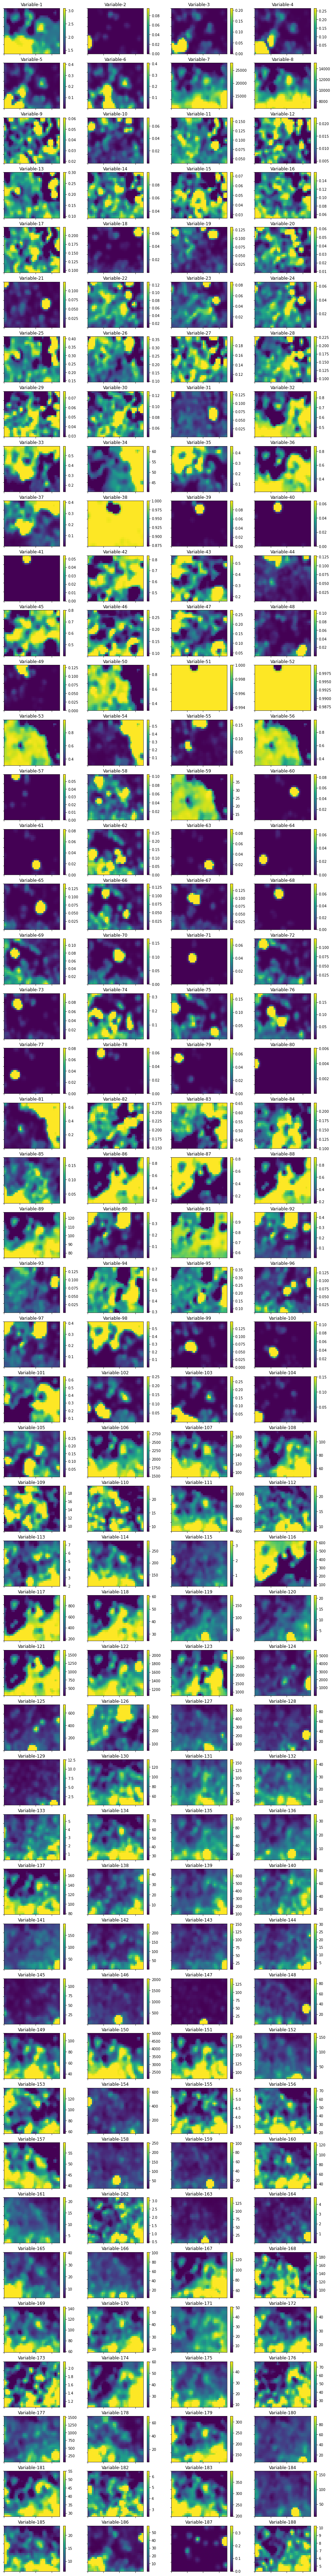

In [50]:
view2D  = View2D(3,3,"rand data",text_size=10)
view2D.show(sm, col_sz=4, which_dim="all", denormalize=True)

# Create a U-Matrix

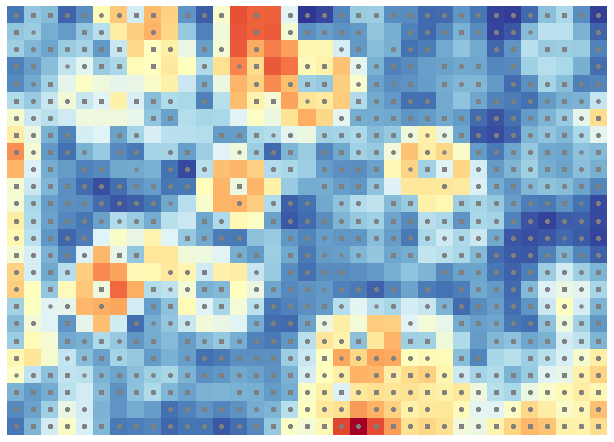

([],
 array([[1.27690423, 1.96472054, 1.85973625, 1.13541335, 1.45892774,
         3.10837407, 3.71940356, 2.48918267, 3.83452996, 3.61868983,
         1.50627567, 1.08125576, 2.95278235, 4.61314159, 4.48802811,
         4.4824816 , 2.62567941, 0.78829957, 0.92531735, 1.40134161,
         2.01967451, 2.03349526, 1.44401089, 1.43768256, 1.17375561,
         1.18306116, 1.52186658, 1.26550092, 0.88970382, 0.8466622 ,
         1.1694689 , 1.89802789, 2.15173403, 1.45365971, 0.87636028],
        [1.95163191, 2.02483289, 1.71922707, 1.55650602, 1.95435742,
         2.25929349, 3.3085217 , 3.66214256, 3.90909212, 3.5622248 ,
         1.97997267, 1.33656519, 2.83303036, 4.57608446, 4.49204996,
         4.52033574, 2.89862759, 1.46691603, 1.57965606, 1.49312553,
         1.54283139, 1.93990437, 1.7417216 , 1.34787747, 1.15914875,
         1.40331605, 1.75794363, 1.42708306, 0.89465325, 1.05131203,
         1.85716764, 2.29775827, 2.2950143 , 1.7741691 , 1.12508835],
        [2.04312831, 1.7980

In [51]:
u = umatrix.UMatrixView(3, 3, 'umat', show_axis=True, text_size=8, show_text=True)
u.build_u_matrix(sm, distance=1, row_normalized=False)
u.show(sm, distance2=1, row_normalized=False, show_data=True,
 contooor=False, blob=False)

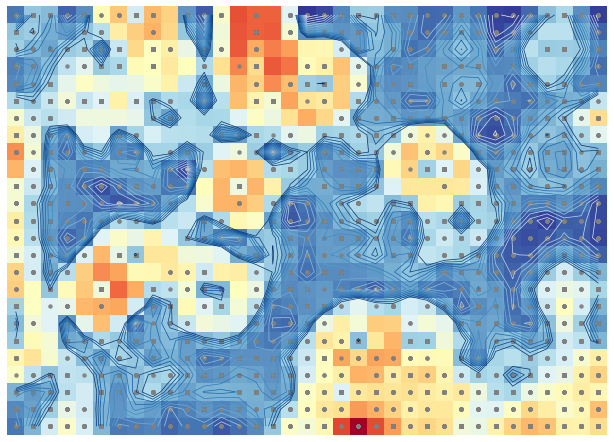

In [52]:
a = u.show(sm, distance2=1, row_normalized=False, show_data=True,
 contooor=True, blob=False)

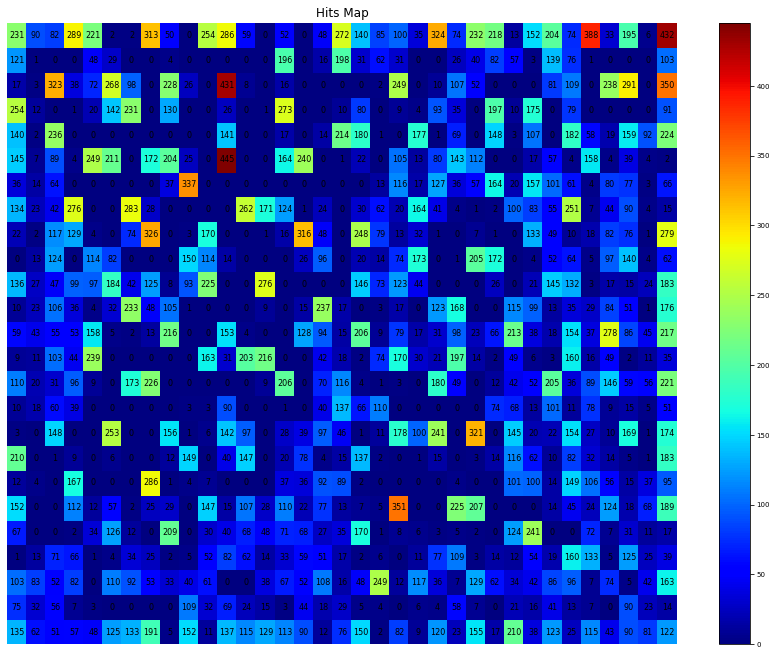

In [53]:
vhts  = BmuHitsView(15,15,"Hits Map",text_size=7)
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=8, logaritmic=False)

In [54]:
for i in range(2,111):
    sm.cluster_labels = KMeans(init='k-means++',max_iter=1000,n_clusters=i).fit_predict(sm.codebook.matrix)
    print(i, silhouette_score(sm.codebook.matrix, labels=sm.cluster_labels), calinski_harabasz_score(sm.codebook.matrix, labels=sm.cluster_labels))

2 0.13245729148351548 134.3868393897552
3 0.12756768368557828 107.85874056132087
4 0.11998766666425816 91.91246736037769
5 0.12921056510066634 81.20376467196654
6 0.11630259743498397 74.22126483891445
7 0.13117831832561339 70.77886402995571
8 0.1276757849670226 65.58360356260482
9 0.1191936212316597 61.33843454134422
10 0.13658882970414302 59.564439186841184
11 0.12718616149079837 56.53864185404419
12 0.1346070917477852 56.856296568684826
13 0.14412492064154553 52.86937001396171
14 0.15742632045198288 53.445870239720705
15 0.16493267891203967 52.456664346749186
16 0.15555267648772114 50.74239722212576
17 0.15140924060865382 50.60218728908147
18 0.16322074281065221 48.72012655037683
19 0.1645343334841022 49.02395514957282
20 0.16518315225670416 48.95822034149442
21 0.1817242865626572 49.9734260987844
22 0.1877376515810679 48.21523058407223
23 0.19440950614790062 49.97807458835248
24 0.20249602252540608 48.1346052741971
25 0.20184072466426486 49.0388117078484
26 0.2026740915555331 48.753

# The cluster size selected is 24 based on the maximization of silhouette score and minimization of Calinski-Harabasz score

In [56]:
sm.cluster_labels = KMeans(init='k-means++',max_iter=1000,n_clusters=24).fit_predict(sm.codebook.matrix)

C:\ProgramData\Anaconda3\lib\site-packages\sompy-1.1.1-py3.8.egg\sompy\visualization\hitmap.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


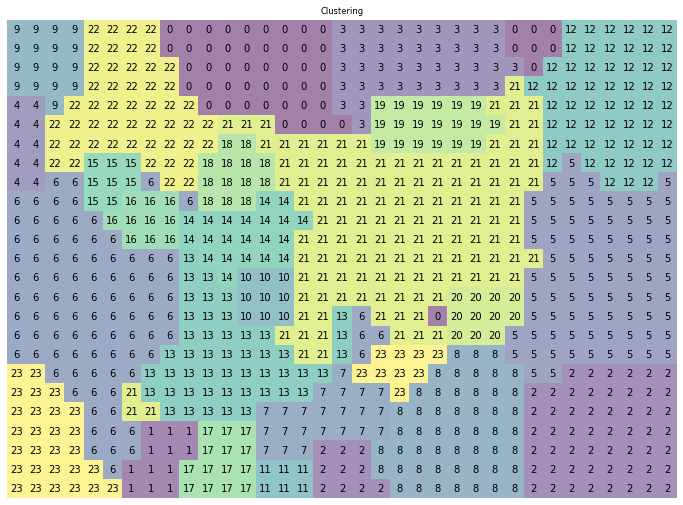

In [58]:
# sm1.cluster()
hits = HitMapView(12,12,"Clustering",text_size=7)
visual = hits.show(sm, labelsize=10)

In [59]:
large_cluster = sm.project_data(Assess)

In [60]:
cluster = sm.cluster_labels

clusterlist = dict()

for i in range(25*35):
    clusterlist[i] = cluster[i]
    
max(cluster)

23

In [61]:
FoodFP = Footprint[:,0:4].sum(axis=1)
ClthFP = Footprint[:,4:10].sum(axis=1)
HousFP = Footprint[:,10:16].sum(axis=1) + Footprint[:,21:33].sum(axis=1)
UtilFP = Footprint[:,16:21].sum(axis=1)
HlthFP = Footprint[:,33:40].sum(axis=1)
TrnsFP = Footprint[:,40:49].sum(axis=1)
EtmtFP = Footprint[:,52:72].sum(axis=1)
OthrFP = Footprint.sum(axis=1) - FoodFP - ClthFP - HousFP - UtilFP - HlthFP - TrnsFP - EtmtFP

# Assign cluster to each household

In [62]:
y_kmeans = np.zeros(len(Assess))

for i in range(len(Assess)):
    y_kmeans[i] = cluster[large_cluster[i]]

In [63]:
Assess1 = Assess.copy()

In [64]:
Assess1["Cluster"] = y_kmeans
Assess1["FPpCp"] = FPSum/HHNum
Assess1["FPpEC"] = FPSum/AdjHH
Assess1["Food"] = FoodFP/HHNum
Assess1["Clothes"] = ClthFP/HHNum
Assess1["Housing"] = HousFP/HHNum
Assess1["Util"] = UtilFP/HHNum
Assess1["Health"] = HlthFP/HHNum
Assess1["Transportation"] = TrnsFP/HHNum
Assess1["Entertainment"] = EtmtFP/HHNum
Assess1["Others"] = OthrFP/HHNum

In [65]:
ClusEmission = np.zeros((24,199))

for i in range(0,24):
    try:
        ClusEmission[i,:] = np.average(Assess1[Assess1["Cluster"] == i], axis=0)
    except:
        pass

In [66]:
ClusSize = np.zeros((24))

for i in range(0,24):
    ClusSize[i] = np.shape(Assess1[Assess1["Cluster"] == i])[0]
    
ClusSize

array([2867.,  753., 5423., 1905.,  448., 5727., 6457.,  829., 3223.,
        947.,  285.,  248., 3174., 3071.,  984.,  259.,  399., 1064.,
        525.,  817.,  412., 7216., 2416., 2972.])

In [68]:
emission = pd.DataFrame(ClusEmission)

colnames = Assess1.columns
emission.columns = colnames

emission.to_excel("Emissions_Group.xlsx")

In [70]:
Result = pd.DataFrame(ClusEmission[:,:8])
Result.columns = ['HHMember','Baby_1','Baby_2','Toddler','Child','Teenager','FPSum','IncomepHH']
Result = Result.join(pd.DataFrame(ClusEmission[:,33]))
Result.columns = ['HHMember','Baby_1','Baby_2','Toddler','Child','Teenager','FPSum','IncomepHH','Age']
Result

,HHMember,Baby_1,Baby_2,Toddler,Child,Teenager,FPSum,IncomepHH,Age
0,3.657830,0.000698,0.011161,0.027555,0.455180,0.749215,29498.794569,18501.025113,48.126962
1,1.723772,0.002656,0.035857,0.051793,0.069057,0.073041,11396.933169,6251.925631,36.993360
2,1.222939,0.000000,0.003135,0.003688,0.009589,0.016412,10830.151737,5621.179974,65.483127
3,2.504462,0.002625,0.037795,0.049869,0.113386,0.158005,34288.083469,15918.857218,51.906562
4,3.705357,1.000000,0.149554,0.319196,0.165179,0.062500,20369.691000,13894.174107,34.883929
5,2.004715,0.000000,0.000000,0.000524,0.002619,0.007159,18484.841064,9204.739480,70.578488
6,1.644262,0.000000,0.007279,0.008363,0.019514,0.043828,14909.499454,9533.105622,43.633421
7,2.412545,0.025332,0.077201,0.117008,0.203860,0.176116,15696.790794,9242.346200,47.617612
8,1.415141,0.000000,0.001862,0.003413,0.004344,0.009618,8419.168954,5311.712690,67.160410
9,5.122492,0.001056,0.288279,0.592397,1.379092,0.845829,27185.085816,16268.513200,42.476241


In [71]:
Details = pd.DataFrame(ClusEmission[:,-11:])

Details.columns = ['Cluster','FPpc','FpEC','Food','Clothes','Housing','Utilities','Health','Transportation','Entertainment','Others']
Details

,Cluster,FPpc,FpEC,Food,Clothes,Housing,Utilities,Health,Transportation,Entertainment,Others
0,0.0,8685.551538,13944.900008,1127.108037,621.230121,1279.776048,2119.909759,241.272270,2171.680617,711.616321,412.958366
1,1.0,7116.849527,8433.231842,1010.440571,444.169847,891.022234,1931.391449,163.526564,1827.689960,462.989965,385.618938
2,2.0,9373.591989,9829.404443,1205.070988,329.772661,1532.368101,3619.315371,348.077475,1352.791260,623.537950,362.658183
3,3.0,15562.663524,21041.832132,1272.129815,694.960477,2616.627560,3477.654745,373.581206,4971.761121,1514.100834,641.847767
4,4.0,5633.496713,10132.528184,776.258358,344.199172,818.693822,1372.145920,172.163057,1571.379481,254.058949,324.597954
5,5.0,9434.788272,12382.075631,1237.902387,345.356339,1506.788411,3414.420127,336.643756,1640.393586,633.595932,319.687735
6,6.0,9715.976754,11300.104453,1206.652926,600.492405,1131.510331,2261.399166,268.947102,2927.847669,806.003135,513.124019
7,7.0,7325.075082,9738.741679,1054.144466,425.509649,1049.054951,2083.998287,196.470660,1688.622236,465.054478,362.220354
8,8.0,6137.424743,6884.684500,1166.486210,312.363747,991.968489,1375.658572,308.443635,1007.964686,646.344089,328.195315
9,9.0,5493.113927,10829.406935,796.838273,366.711148,770.541162,1474.281391,138.027792,1325.915863,377.349938,243.448359
